# 9
Переход от непрерывной системы к дискретной по формулe  
$$\xi_{k+1}=e^{A(t_{k+1}-t{k})}\xi_k+\int_{t_k}^{t_{k+1}}e^{A(t_{k+1}-s)Bu(s)ds},\ \xi_k = (\theta_{1,k}, \theta_{2,k}, \dot{\theta}_{1,k}, \dot{\theta}_{2,k})^T$$
Считая, что управление является кусочно постоянной функцией, то есть $u(t) = u_k = const$ при $t_k \leqslant t < t_{k+1}$ и $t_{k+1} - t_k = h = const$.

In [54]:
# np.dot(A, h) <=> A * h, если h - скаляр
# np.matmul <=> @

import numpy as np
import sympy as sp
from sympy import Eq, solve, factor
from scipy.linalg import expm
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from numpy.linalg import det, eig 

# Подынтегральное выражение для перехода к матрице Bb в дискретной системе
def integrand(s, A, B):
    return expm(np.dot(A, s)) @ B

# Метод Монте-Карло для численного интегрирования (применяется при вычислении матрицы Bd)
def monte_carlo_integration(A, B, num_samples, s_min, s_max):
    total = 0.0
    
    for _ in range(num_samples):
        s = np.random.uniform(s_min, s_max)
        total += integrand(s, A, B)
    
    average = total / num_samples
    result = average * (s_max - s_min)
    return result

# Проверка управляемости системы 4 порядка
def control_check(A, B):
  #C = np.vstack((B.T, (A @ B).T, (A @ A @ B).T, (A @ A @ A @ B).T)).T
  rank_A = np.linalg.matrix_rank(A)
  C = np.array(B)
  for i in range(1, rank_A, 1):
    tmp = np.linalg.matrix_power(A, i) @ B
    C = np.hstack((C, tmp))
  if np.linalg.matrix_rank(C) == A.shape[0]:
    print('Система управляема')
    print('Ранг матрицы управлемости:', np.linalg.matrix_rank(C))
  else:
    print('Система неуправляема') # добавить подпространство управляемости и неуправляемости
    print('Ранг матрицы управлемости:', np.linalg.matrix_rank(C))
    print('Управляемое подпространство имеет размерность:', np.linalg.matrix_rank(C))
    print('Неуправляемое подпространство имеет размерность:', A.shape[0] - np.linalg.matrix_rank(C))

# Проверка наблюдаемости системы 4 порядка
def observer_check(A, C):
  #O = np.vstack((C, (C @ A), (C @ A @ A), (C @ A @ A @ A)))
  rank_A = np.linalg.matrix_rank(Ad)
  O = np.array(Cd)
  for i in range(1, rank_A, 1):
    tmp = Cd @ np.linalg.matrix_power(Ad, i)
    O = np.vstack((O, tmp))
  if np.linalg.matrix_rank(O) == A.shape[0]:
    print('Система наблюдаема')
    print('Ранг матрицы наблюдаемости:', np.linalg.matrix_rank(O))
  else:
    print('Система ненаблюдаема') # добавить подпространство управляемости и неуправляемости
    print('Ранг матрицы наблюдаемости:', np.linalg.matrix_rank(O))
    print('Наблюдаемое подпространство имеет размерность:', np.linalg.matrix_rank(O))
    print('Ненаблюдаемое подпространство имеет размерность:', A.shape[0] - np.linalg.matrix_rank(O))
    
# Исходная дискретная система
def discrete_system(Ad, Bd, vth, xi):
  return Ad @ xi + Bd @ vth @ xi

# Наблюдатель (наблюдатель полного порядка)
def observer(Ad, Bd, Cd, y, xi):
  return Ad @ xi + Bd @ vth @ xi + L @ (y - Cd @ xi)

# Вычисление невязки
def residual(Ad, Bd, Cd, vth):
  r = np.array([[0., 0., 0., 0.]])
  rmax = np.array([[0., 0., 0., 0.]])
  xi_true = np.array([[1., 0., 0., 0.]]).T
  xi_approx = np.array([[0., 0., 0., 0.]]).T
  for i in np.arange(0., 10., 0.1):
    y = Cd @ xi_true
    #print(xi_true, xi_approx)
    xi_true = discrete_system(Ad, Bd, vth, xi_true)
    xi_approx = observer(Ad, Bd, Cd, y, xi_approx)
    r = xi_true - xi_approx # residual
    if np.all(rmax < r):
      rmax = r
    print(r.T)
  return rmax

In [50]:
O = np.vstack((Cd, (Cd @ Ad), (Cd @ Ad @ Ad), (Cd @ Ad @ Ad @ Ad)))
print(O)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.40859323e+00 -2.15057780e-01  1.12094825e-01 -5.46447795e-03]
 [-6.45173341e-01  1.55734406e+00 -1.88784915e-02  1.14316607e-01]
 [ 3.20976211e+00 -1.24850782e+00  3.20702474e-01 -6.10437471e-02]
 [-3.74552346e+00  4.06399200e+00 -1.97558127e-01  3.54177084e-01]
 [ 9.09662270e+00 -4.94119829e+00  8.65212299e-01 -3.09739249e-01]
 [-1.48235949e+01  1.24556944e+01 -9.86314787e-01  1.04551868e+00]]


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.40859323e+00 -2.15057780e-01  1.12094825e-01 -5.46447795e-03]
 [-6.45173341e-01  1.55734406e+00 -1.88784915e-02  1.14316607e-01]
 [ 3.20976211e+00 -1.24850782e+00  3.20702474e-01 -6.10437471e-02]
 [-3.74552346e+00  4.06399200e+00 -1.97558127e-01  3.54177084e-01]
 [ 9.09662270e+00 -4.94119829e+00  8.65212299e-01 -3.09739249e-01]
 [-1.48235949e+01  1.24556944e+01 -9.86314787e-01  1.04551868e+00]]


In [16]:
# Матрицы A и B исходной непрерывной системы
A = np.array([[0., 0., 1., 0.], 
              [0., 0., 0., 1.], 
              [74.57425435, -38.29562765, -0.18354406, 0.24176003], 
              [-114.88688294, 101.44934008, 0.28276253, -0.64044897]])

B = np.array([[0., 0., 0.95054085,-1.46437503]]).T

# # Тестовая непрерывная система
# A_test = np.array([
#     [0., 0., 1., 0.],
#     [0., 0., 0., 1.],
#     [0., 0.8096, -10.6755, -0.0073],
#     [0., 47.7403, -48.0369, -0.4310]
# ])

# B_test = np.array([[0., 0., 1.4018, 6.3077]]).T

In [3]:
# # Матричное умножение
# print(A @ A, '\n')
# print(A.dot(A), '\n')
# print(A * A, '\n')
# print(np.dot(A, A), '\n')
# print(np.matmul(A, A), '\n')
# print('_________________________________________________________________')
# print(A @ A_test, '\n')
# print(A.dot(A_test), '\n')
# print(A * A_test, '\n')
# print(np.dot(A, A_test), '\n')
# print(np.matmul(A, A_test), '\n')
# print('_________________________________________________________________')
# print(A @ B, '\n')
# print(A.dot(B), '\n')
# print(A * B, '\n')
# print(np.dot(A, B), '\n')
# print(np.matmul(A, B), '\n')
# print('_________________________________________________________________')
# print(B.T @ B, '\n')
# print(B.T.dot(B), '\n')
# print(B.T * B, '\n')
# print(np.dot(B.T, B), '\n')
# print(np.matmul(B.T, B), '\n')
# print('_________________________________________________________________')
# print(A.dot(0.1), '\n')
# print(A * 0.1, '\n')
# print(np.dot(A, 0.1), '\n')
# print('_________________________________________________________________')

In [17]:
# Преобразование непрерывной системы к дискретной

# Параметры
h = 0.1 # t_next - t_cur
num_samples = 1000
s_min = 0.
s_max = h

Bd = monte_carlo_integration(A, B, num_samples, s_min, s_max)
Ad = expm(A * h)
control_check(Ad, Bd)
# Для тестовой системы

# B_testd = monte_carlo_integration(A_test, B_test, num_samples, s_min, s_max)
# A_testd = expm(A_test * h)
# control_check(A_testd, B_testd)

Система управляема
Ранг матрицы управлемости: 4


Полученная дискретная система имеет вид:
$\xi_{k+1} = A_d\xi_k + B_du_k$

Так как полученная дискретная система управляема, то существуют такие матрицы обратной связи $\theta$, что все собственные числа матрицы замкнутой системы $A_{d} + B_{d}\theta$ **лежат внутри единичного круга комплексной плоскости**. Для построения такой матрицы $\theta$ воспользуемся алгоритмом модального управления.  

Нужно построить для полученной дискретной системы закон управления в виде линейной обратной связи по состоянию $u_{k} = a_{1}\theta_{1,k}+a_{2}\theta_{2,k}+a_{2}\dot{\theta}_{1,k}+a_{2}\dot{\theta}_{2,k}$ так, чтобы:
- пара собственных чисел $\lambda_{1} \approx e^{12.116h}$ и $\lambda_{2} \approx e^{4.469h} $ перешла в заданную пару вещественных чисел внутри единичного круга на комплексной плоскости.
- пара собственных чисел $\lambda_{1} \approx e^{12.116h}$ и $\lambda_{2} \approx e^{4.469h} $ перешла в заданную пару комплексно сопряженных чисел внутри единичного круга на комплексной плоскости.

In [158]:
# Лямбды из 9-10 заданий в методичке, l - lambda
lambda_1 = np.exp(12.116*h)
lambda_2 = np.exp(4.469*h)
print(lambda_1, lambda_2, '\n')

# Находим собственные числа матриц
# Для дискретной системы
w, v = np.linalg.eig(Ad)
print(w)
print(v)
# # Для тестовой системы
# w, v = np.linalg.eig(A_testd.T)
# l1_test, l2_test, l3_test, l4_test = w

3.3588545227436857 1.5634579456743005 

[3.35761591 1.56340232 0.27651589 0.63444294]
[[-0.03534204  0.12425756 -0.03292198 -0.12543815]
 [ 0.07430377  0.17958286  0.07022297 -0.17418777]
 [-0.42807383  0.55526283  0.42320773  0.57075353]
 [ 0.89999038  0.80249189 -0.90270709  0.79256816]]


Как видно, собственные числа матрицы Ad, полученные с помощью метода пакета numpy похожи на те, что заданы в методичке

In [159]:
# Посмотрим на собственные числа - кандидаты на свдиг и их правые собственные векторы
print(w[0], w[1])
print(v[:, 0],v[:, 1])

3.3576159078288983 1.5634023230798166
[-0.03534204  0.07430377 -0.42807383  0.89999038] [0.12425756 0.17958286 0.55526283 0.80249189]


Внутрь единичного круга нужно передвинуть $\lambda_1$ и $\lambda_2$. Выберем в качестве новых значений $\lambda_1' = -\lambda_3$ и $\lambda_2' = -\lambda_4$. Построим преобразование, приводящее матрицу $A_d$ к блочной нижнетреугольной форме так, чтобы в начале главной диагонали располагались числа $\lambda_1$ и $\lambda_2$. Для этого найдем левые собственные векторы $v_1$ и $v_2$, соответсвующие собственным числам $\lambda_1$ и $\lambda_2$, и дополним их произвольными векторами, например базисными векторами $e_3$ и $e_4$, до линейно независимой системы, тогда матрица преобразования запишется так  

In [112]:
# Выберем новые значения собственных чисел (желаемый спектр)
l1_ = -w[2]
l2_ = -w[3]
# Комплексно сопряженные
l1C_ = -w[2] + 0.5j
l2C_ = -w[2] - 0.5j
print(l1, l2, l1C, l2C)

-0.27651589418192096 -0.6344429428811563 (-0.27651589418192096+0.5j) (-0.27651589418192096-0.5j)


### Поиск theta для дискретной системы

In [113]:
# Найдем левые собственные векторы, соответствующие собственным числа l1 и l2 (используем транспонированную исходную матрицу дискретной системы)
w, vleft = np.linalg.eig(Ad.T)
# Составляем матрицу перехода, состояющую из векторов собственных чисел, которые мы будем двигать и дополняем до базиса исходной системы
vleft1 = vleft[:, 0] # или vl1 = vl.T[0]
vleft2 = vleft[:, 1]
# Eдиничныe базисные векторы
e3 = np.array([0., 0., 1., 0.])
e4 = np.array([0., 0., 0., 1.])
# Матрица преобразования
p_inv = np.vstack((vleft1, vleft2, e3, e4)) # inv - inverse
p = np.linalg.inv(p_inv)
# print(p_inv, '\n')
# # Проверка на свойство обратной матрицы
# print(p_inv @ p, '\n')
# print(p @ p_inv, '\n')
# Переходим в новый базис
AdCir = p_inv @ Ad @ p
BdCir = p_inv @ Bd
# theta_1, theta_2, вектор с theta (Используем SymPy)
th1, th2 = sp.symbols('th1 th2')
vthCir = sp.Matrix([[th1, th2, 0., 0.]])
BdCir = sp.Matrix(BdCir.tolist())
AdCir = sp.Matrix(AdCir.tolist())
# Построение матрицы обратной связи
AcCir = AdCir + BdCir @ vthCir 
# Построение характеристического полинома матрицы обратной связи
lambda_ = sp.symbols('lambda_')
P = AcCir[:2, :2].charpoly(lambda_) # Нам нужен только блок A[:2, :2], состоящий ячеек на пересечении первых двух строк и столбцов
print(factor(P.as_expr())) 

5.24930451030945*(0.190501427005432*lambda_**2 - 0.0045961582644267*lambda_*th1 + 0.00119591739159821*lambda_*th2 - 0.937460995307857*lambda_ + 0.0071856445078472*th1 - 0.0040154312584794*th2 + 1.0)


In [114]:
# Пара вещественных чисел
# Берем коэффициенты в квадратном уравнении получившегося полинома матрицы обратной связи (просто копирую)
coef1 = 5.24930451030945*(-0.0045961582644267*th1 + 0.00119591739159821*th2 - 0.937460995307857)
coef0 = 5.24930451030945*(0.00726040274497154*th1 - 0.00403149675311616*th2 + 1.0)
# Составляем систему линейных уравнений для поиска th1 и th2. Вместо lambda подставляем желаемые собственные значения
eq1 = Eq(coef1, -(l1_ + l2_))
eq2 = Eq(coef0, l1_*l2_)
sol = solve((eq1, eq2), (th1, th2))
# Находим theta
tmp = vthCir.subs([(th1, sol[th1]), (th2, sol[th2])])
vth = tmp @ p_inv
vth

Matrix([[48.252999415866, 349.059638876938, 49.5880970657553, 48.6420076424623]])

In [115]:
#Решение СЛУ с помощью SciPY 

def equations(variables):
    th1, th2 = variables
    eq1 = 5.24930451030945*(-0.0045961582644267*th1 + 0.00119591739159821*th2 - 0.937460995307857) + (l1_ + l2_)
    eq2 = 5.24930451030945*(0.00726040274497154*th1 - 0.00403149675311616*th2 + 1.0) - (l1_*l2_)
    return [eq1, eq2]

# Начальное приближение
initial_guess = [0, 0]

solution = fsolve(equations, initial_guess)

th1_sol, th2_sol = solution
print("th1 =", th1_sol)
print("th2 =", th2_sol)

th1 = -337.48282664563993
th2 = -368.02251741625906


In [116]:
sol[th1], sol[th2]

(-337.482826645640, -368.022517416259)

In [71]:
# Пара комплексно сопряженных чисел
eq1 = Eq(coef1, -(l1C_ + l2C_))
eq2 = Eq(coef0, l1C_*l2C_)
sol = solve((eq1, eq2), (th1, th2))
tmp = vthCir.subs([(th1, sol[th1]), (th2, sol[th2])])
vthC = tmp @ p_inv
vthC

Matrix([[98.0034233764338, 410.63578021901, 65.0901386150132, 58.8853755056218]])

### Поиск theta для тестовой системы

In [44]:
# # Eдиничныe базисные векторы
# e3 = np.array([1., 0., 0., 0.])
# e4 = np.array([0., 1., 0., 0.])
# p_inv = np.vstack((v[:,3], v[:,0], e3, e4)) # inv - inverse
# p = np.linalg.inv(p_inv)
# # print(p_inv, '\n')
# # # Проверка на свойство обратной матрицы
# # print(p_inv @ p, '\n')
# # print(p @ p_inv, '\n')
# # Переходим в новый базис
# A_testdCir = p_inv @ A_testd @ p
# B_testdCir = p_inv @ B_testd
# # theta_1, theta_2, вектор с theta (Используем SymPy)
# th1, th2 = sp.symbols('th1 th2')
# vth_testCir = sp.Matrix([[th1, th2, 0., 0.]])
# Bd_testCirTh = sp.Matrix(B_testdCir.tolist())
# Ad_testCirTh = sp.Matrix(A_testdCir.tolist())
# # Построение матрицы обратной связи
# Ac = Ad_testCirTh + Bd_testCirTh @ vth_testCir 
# # Построение характеристического полинома матрицы обратной связи
# lambda_ = sp.symbols('lambda_')
# P = Ac[:2, :2].charpoly(lambda_) # Нам нужен только блок A[:2, :2], состоящий ячеек на пересечении первых двух строк и столбцов
# print(factor(P.as_expr()))

In [47]:
# # Берем коэффициенты в квадратном уравнении получившегося полинома матрицы обратной связи (просто копирую)
# coef1 = 2.92356543651555*(- 0.00446851013514439*th1 + 0.0150997587534359*th2 - 1.0)
# coef0 = 2.92356543651555*(0.00859547164868319*th1 - 0.0150997587534358*th2 + 0.657951900952883)
# # Новые собственные числа в желаемом спектре
# l1_test_ = -w[1]
# l2_test_ = -w[2]
# # Составляем систему линейных уравнений для поиска th1 и th2. Вместо lambda подставляем желаемые собственные значения
# eq1 = Eq(coef1, (l1_test_ + l2_test_))
# eq2 = Eq(coef0, l1_test_*l2_test_)
# sol = solve((eq1, eq2), (th1, th2))
# # Находим theta
# tmp = vth_testCir.subs([(th1, sol[th1]), (th2, sol[th2])])
# vth_test = tmp @ p_inv
# vth_test

In [107]:
# #Решение СЛУ с помощью SciPY 

# def equations(variables):
#     th1, th2 = variables
#     eq1 = 2.92356543651555*(- 0.00446851013514439*th1 + 0.0150997587534359*th2 - 1.0) + (l1_test_ + l2_test_)
#     eq2 = 2.92356543651555*(0.00859547164868319*th1 - 0.0150997587534358*th2 + 0.657951900952883) - (l1_test_*l2_test_)
#     return [eq1, eq2]

# # Начальное приближение
# initial_guess = [0, 0]

# solution = fsolve(equations, initial_guess)

# th1_sol, th2_sol = solution
# print("th1 =", th1_sol)
# print("th2 =", th2_sol)

# 10
Предположим, что непосредственному наблюдению доступны только углы отклонения маятника $\theta_1(t_k)$ и $\theta_2(t_k)$ в моменты времени $t_k$. Синтезируем асимптотический наблюдатель полного порядка.

Заметка: Пусть дана система линейных уравнений $Ax=b$. $x$ - истинное (точное) решение решение системы, $x^*$ - приближенное решение, полученное с помощью численных методов. Величины характеризующие степень отклонения полученного приближенного решения от точного: погрешность и невязка. Погрешность $\Delta{x} = x - x^*$ , Невязка $r = Ax^* - b$ - разность между левой и правой частями уравнений при подстановке в них приближенного решения.

Рассмотрим случай неизмеряемого состояния, когда отсутствует полная информация о состоянии системы. $$y = Cx,\ 
C = \begin{bmatrix}
1\ 0\ 0\ 0\\\
0\ 1\ 0\ 0\
\end{bmatrix}$$

Будем искать управление u в виде линейной обратной связи по восстановленному состоянию. Для этого используем наблюдатель, позволяющий восстановить коспоненты вектора состояния по измеряемому выходу.  
Наблюдателем (или наблюдателем полного порядка) для исходной системы, называется система вида $$\hat{\xi}_{k+1}= A_{d}\hat{\xi}_k + B_{d}u+L(y-C_{d}\hat{\xi}_{k}),\ \hat{\xi}_k(0)=0$$
где $\hat{\xi}_{k}$ - состояние наблюдателя, размерность которого совпадает с размерностью состояния $\xi_{k}$ исходной дискретной системы, а матрица $L$ - матрица коэффициентов усиления наблюдателя. Наблюдатель будет асимптотически устойчивым, когда ошибка восстановления $\varepsilon = \xi_k - \hat{\xi}_k$ стремится к нулю независимо от начального состояния, а это возможно тогда и только тогда, когда матрица $A_d - LC_d $ устойчива. Таким образом, синтез наблюдателя состоит в определении матрицы коэффициентов усиления $L$, при которой полюса наблюдателя (собственные числа матрицы $A_d - LC_d$) будут расположены в левой полуплоскости комплексной плоскости. Данная задача разрешима, если пара матрицы $(A_d, C_d)$ является детектируемой.

In [117]:
Cd = np.array([
    [1., 0., 0., 0.],
    [0., 1., 0., 0.]
])
# Проверим наблюдаемость дискретной системы
observer_check(Ad, Cd)
# # Проверим наблюдаемость непрерывной тестовой системы
# observer_check(A_test, Cd)

Система наблюдаема
Ранг матрицы наблюдаемости: 4


Система наблюдаема, поэтому задача синтеза наблюдателя разрешима. Согласно теореме о разделении, задачи синтеза модального регулятора (определения матрицы $\theta$) и наблюдателя (вычисления матрицы $L$) могут решаться независимо. Матрица $\theta$ для случаев $(a)$ и $(b)$ была найдена ранее, поэтому остается найти матрицу $L$.

Сведем задачу построения матрицы $L$ к задаче синтеза модального регулятора. Воспользуемся принципом двойственности: пара $(Ad, Cd)$ детектируема тогда и только тогда, когда пара $(Ad^T, Cd^T)$ стабилизируема. Следовательно матрицы $L$ может быть найдена как матрица стабилизирующего регулятора для пары $(Ad^T, Cd^T)$: $$(Ad - LCd)^T = Ad^T - Cd^TL^T$$
Построим преобразование $P$, приводящее матрицу $Ad^T$ к блочному нижнетреугольному виду. Для этого правые собственные векторы $v_1 = (-0.03534204\ 0.07430377\ -0.42807383\ 0.89999038)^T$ и $v_2 = (0.12425756\ 0.17958286\ 0.55526283\ 0.80249189)^T$ матрицы $Ad$, соответствующие собственным числам $\lambda_1$ и $\lambda_2$, дополним произвольными векторами до линейно независимой системы, например $s_1 = (0, 0, 1, 0)^T$ и $s_2 = (0, 0, 0, 1)^T$.

In [146]:
# Базисные векторы для дискретной системы
s1 = np.array([0., 0., 1., 0.])
s2 = np.array([0., 0., 0., 1.])
# Строим матрицы преобразования системы
P_inv = np.vstack((v[:,0], v[:,1], s1, s2))
P =  np.linalg.inv(P_inv)
#print(p_inv,'\n','rank:', np.linalg.matrix_rank(p_inv))
th1, th2 = sp.symbols('th1 th2')
LCir = sp.Matrix([[th1, th2, 0., 0.], [th1, th2, 0., 0.]])
AdT = sp.Matrix(Ad.T.tolist())
CdT = sp.Matrix(Cd.T.tolist())
P_inv = sp.Matrix(P_inv.tolist())
P = sp.Matrix(P.tolist())
# Построение блочно-нижнетреугольной матрицы
LTM = P_inv @ (AdT @ P - CdT @ LCir)# lower triangular matrix
# Берем нужный нам блок
LTM

Matrix([
[    3.3576159078289 - 0.0389617238564005*th1, -0.0389617238564005*th2 - 9.99200722162641e-16, 1.81799020282369e-15, -1.27675647831893e-15],
[4.44089209850063e-16 - 0.303840417808762*th1,       1.56340232307981 - 0.303840417808762*th2, 7.07767178198537e-16, -5.55111512312578e-16],
[                           -1.44265971655252,                              0.491787249220734,    0.495837678948388,     0.294340731300899],
[                           0.974736221041808,                               0.23326299540605,    0.103278787578623,     0.415121158114687]])

Случай $(a)$:

In [166]:
# Поиск значений th1, th2 для желаемого спектра
lambda_ = sp.symbols('lambda_')
PLTM = LTM[:2, :2].charpoly(lambda_)
print(factor(PLTM.as_expr()))

5.24930451030945*(0.190501427005432*lambda_**2 + 0.00742226399323587*lambda_*th1 + 0.0578820331744959*lambda_*th2 - 0.937460995307857*lambda_ - 0.0116039847695367*th1 - 0.194345635364168*th2 + 1.0)


In [175]:
coef1 = 5.24930451030945*(+ 0.00742226399323587*th1 + 0.0578820331744959*th2 -0.937460995307857) # где coef1 - это коэффициент перед 1 степенью
coef0 = 5.24930451030945*(-0.0116039847695367*th1 -0.194345635364168*th2 + 1.0) # coef0 - свободный член
eq1 = Eq(coef1, -(l1_ + l2_))
eq2 = Eq(coef0, l1_*l2_)
sol = solve((eq1, eq2), (th1, th2))
tmp = LCir.subs({th1: sol[th1], th2: sol[th2]})
La = (tmp @ P_inv).T
La

Matrix([
[-8.25632819548038, -8.25632819548038],
[ 14.0883052634522,  14.0883052634522],
[-92.9579033262312, -92.9579033262312],
[ 180.824167908737,  180.824167908737]])

In [171]:
#Решение СЛУ с помощью SciPY 
def equations(variables):
    th1, th2 = variables
    eq1 = 5.24930451030945*(+ 0.00742226399323587*th1 + 0.0578820331744959*th2 -0.937460995307857) + (l1_ + l2_)
    eq2 = 5.24930451030945*(-0.0116039847695367*th1 -0.194345635364168*th2 + 1.0) - (l1_*l2_)
    return [eq1, eq2]

# Начальное приближение
initial_guess = [0, 0]

solution = fsolve(equations, initial_guess)

th1_sol, th2_sol = solution
print("th1 =", th1_sol)
print("th2 =", th2_sol)
pass

th1 = 207.53211145789015
th2 = -7.417814148099314


In [169]:
sol[th1], sol[th2]

(207.532111457891, -7.41781414809936)

In [20]:
# #Решение СЛУ с помощью SciPY 
# def equations(variables):
#     th1, th2 = variables
#     eq1 = 6.5418046213536*(-0.0232544932369129*th1 + 0.152863018368941*th2 -1.0) - (l1_ + l2_)
#     eq2 = 6.5418046213536*(1.32587533286638e-18*th1 -1.0*th2) - (l1_*l2_)
#     return [eq1, eq2]

# # Начальное приближение
# initial_guess = [0, 0]

# solution = fsolve(equations, initial_guess)

# th1_sol, th2_sol = solution
# print("th1 =", th1_sol)
# print("th2 =", th2_sol)

Случай $(b)$:

In [83]:
eq1 = Eq(coef1, -(l1C_ + l2C_))
eq2 = Eq(coef0, l1C_*l2C_)
sol = solve((eq1, eq2), (th1, th2))
tmp = LCir.subs([(th1, sol[th1]), (th2, sol[th2])])
Lb = (tmp @ P_inv).T
Lb

Matrix([
[-9.34139727454294, -9.34139727454294],
[  15.531301391214,   15.531301391214],
[-104.294486009979, -104.294486009979],
[ 200.912464914003,  200.912464914003]])

In [176]:
# SymPy to NumPy
vth = np.array(vth.tolist(), dtype=np.float64)
vthC = np.array(vthC.tolist(), dtype=np.float64)
La = np.array(La.tolist(), dtype=np.float64)
Lb = np.array(Lb.tolist(), dtype=np.float64)

In [177]:
def discrete_system(xi, Ad, Bd, theta):
  return Ad @ xi + Bd @ theta @ xi

def observer(xi, xiApprox, Ad, Bd, Cd, theta, L):
  y = Cd @ xi
  return Ad @ xiApprox + Bd @ theta @ xiApprox + L @ (y - Cd @ xiApprox)

h = 0.1
xi = np.array([[0., -0.2, 0., 0.]]).T
xiApprox = np.array([[0., 0., 0., 0.]]).T
xis = xi
xiApproxs = xiApprox
# Случай (a)
u = vth @ xi
uApprox = vth @ xiApprox


ts = [0] # list
while ts[-1] < 3:
  t = ts[-1]

  # Невязка
  r = discrete_system(xiApprox, Ad, Bd, vth) - observer(xi, xiApprox, Ad, Bd, Cd, vth, La)
  print(r.T)
    
  xiApprox = observer(xi, xiApprox, Ad, Bd, Cd, vth, La)
  xi = discrete_system(xi, Ad, Bd, vth)

  xis = np.append(xis, xi, axis=1)
  xiApproxs = np.append(xiApproxs, xiApprox, axis=1)

  u = np.append(u, vth @ xi, axis=1)
  uApprox = np.append(uApprox, vth @ xiApprox, axis=1)
  ts.append(t+h)

[[ -1.65126564   2.81766105 -18.59158067  36.16483358]]
[[   9.0962159   -15.52145982  102.41418925 -199.21878496]]
[[ -56.80421025   96.92868733 -639.55794386 1244.08499858]]
[[  349.72580648  -596.75969797  3937.55879612 -7659.4433332 ]]
[[ -2147.95045471   3665.18638556 -24183.74923954  47042.86754195]]
[[  13201.1839753   -22526.03158203  148631.97715896 -289122.84628536]]
[[ -81124.09498272  138427.27508863 -913375.24384743 1776721.64009046]]
[[   498524.09054588   -850663.80629586   5612876.94935977
  -10918316.43814315]]
[[ -3063540.19884309   5227516.21377948 -34492363.54193998
   67095456.26032826]]
[[ 1.88261147e+07 -3.21242136e+07  2.11963006e+08 -4.12316037e+08]]
[[-1.15690537e+08  1.97410224e+08 -1.30255841e+09  2.53377101e+09]]
[[ 7.10943314e+08 -1.21312843e+09  8.00450252e+09 -1.55705696e+10]]
[[-4.36890007e+09  7.45493595e+09 -4.91893952e+10  9.56845102e+10]]
[[ 2.68478337e+10 -4.58121900e+10  3.02279448e+11 -5.88001962e+11]]
[[-1.64985731e+11  2.81525793e+11 -1.8575724

In [144]:
uApprox

array([[ 0.00000000e+00, -1.33392067e+03,  1.93357793e+03,
        -1.20379336e+03,  9.67678437e+02, -5.68106461e+02,
         4.22158350e+02, -2.42598223e+02,  1.74257804e+02,
        -9.83001899e+01,  6.95873250e+01, -3.89252024e+01,
         2.75824842e+01, -1.54596139e+01,  1.10312267e+01,
        -6.21585929e+00,  4.45370815e+00, -2.51617227e+00,
         1.80189299e+00, -1.01725790e+00,  7.26805552e-01,
        -4.09608525e-01,  2.92265027e-01, -1.64573260e-01,
         1.17446754e-01, -6.61493755e-02,  4.72425327e-02,
        -2.66233664e-02,  1.90221124e-02, -1.07227956e-02,
         7.66088152e-03]])

In [179]:
h = 0.01
xi = np.array([[0., -0.2, 0., 0.]]).T
xiApprox = np.array([[0., 0., 0., 0.]]).T
xis = xi
xiApproxs = xiApprox
# Случай (b)
u = vthC @ xi
uApprox = vthC @ xiApprox


ts = [0] # list
while ts[-1] < 3:
  t = ts[-1]

  # Невязка
  r = discrete_system(xiApprox, Ad, Bd, vthC) - observer(xi, xiApprox, Ad, Bd, Cd, vthC, La)
  print(r.T)
    
  xiApprox = observer(xi, xiApprox, Ad, Bd, Cd, vthC, La)
  xi = discrete_system(xi, Ad, Bd, vthC)

  xis = np.append(xis, xi, axis=1)
  xiApproxs = np.append(xiApproxs, xiApprox, axis=1)

  u = np.append(u, vthC @ xi, axis=1)
  uApprox = np.append(uApprox, vthC @ xiApprox, axis=1)
  ts.append(t+h)

[[ -1.65126564   2.81766105 -18.59158067  36.16483358]]
[[   9.39302636  -16.02792666  105.75597481 -205.71931447]]
[[ -62.85121911  107.24708854 -707.64114647 1376.5222419 ]]
[[  410.62750191  -700.68018853  4623.25027813 -8993.26850825]]
[[ -2678.96139111   4571.28459206 -30162.39520929  58672.68753593]]
[[  17488.8663536   -29842.38054346  196906.94329148 -383028.58500562]]
[[ -114155.34851826   194790.63323347 -1285273.74402841  2500148.42184271]]
[[   745131.71973706  -1271466.30809605   8389429.38418348
  -16319339.54340828]]
[[-4.86374196e+06  8.29931658e+06 -5.47608143e+07  1.06522182e+08]]
[[ 3.17473679e+07 -5.41725813e+07  3.57443247e+08 -6.95308041e+08]]
[[-2.07226338e+08  3.53603664e+08 -2.33315893e+09  4.53852235e+09]]
[[ 1.35263985e+09 -2.30809661e+09  1.52293564e+10 -2.96245461e+10]]
[[-8.82916033e+09  1.50657657e+10 -9.94074136e+10  1.93369926e+11]]
[[ 5.76310628e+10 -9.83395991e+10  6.48867467e+11 -1.26219413e+12]]
[[-3.76178399e+11  6.41897463e+11 -4.23538823e+12  8.2

# 11
Используя результаты из предыдущего пукнта, построим регулятор в виде линейной обратной связи по состоянию наблюдателя

# offtop

In [30]:
# Получение управления для исходной системы, которое переводит числа 4.46 и 12.11.
def get_control(lmd1, lmd2): 
    # Нахождение собственных чисел и левых векторов (применяется транспонированная матрица)
    lmds, left_vecs = np.linalg.eig(A.T)
    # Матрица преобразования
    inv_P = np.append(left_vecs[:, -2:].T, np.identity(4)[:2, :], axis=0) 
    P = np.linalg.inv(inv_P)
    # Переход к новому базису
    A_ = inv_P @ A @ P
    B_ = inv_P @ B
    # Поиск коэффициентов theta в новом базисе
    theta_ = np.linalg.solve([
        B_[:2, 0],
        [det(np.append(B_[:2], A_[:2, 1].reshape(-1, 1), axis=1)), det(np.append(A_[:2, 0].reshape(-1, 1), B_[:2], axis=1))]
    ], [(lmd1 + lmd2) - (A_[0, 0] + A_[1, 1]), (lmd1*lmd2) - det(A_[:2, :2])])
    theta_ = np.array([[*theta_, 0, 0]])
    # Коэффициенты theta в исходном базисе
    return theta_ @ inv_P

def rk4(f, t, x, theta, h=1e-4): # Численное дифференцирование - Метод Рунге — Кутты
    k0 = h * f(t, x, theta)
    k1 = h * f(t + h/2, x + k0/2, theta)
    k2 = h * f(t + h/2, x + k1/2, theta)
    k3 = h * f(t + h, x + k2, theta)

    return x + (k0 + 2*k1 + 2*k2 + k3)/6

def get_lin_system(k1, k2, kf, ks, m1, m2, l1, l2, L1, L2, I1, I2, Ad, A_testd, Bd, B_testd):
    g = 9.81
    A11 = I1 + m1 * l1**2 + m2 * L1**2
    A12 = m2 * l2 * L1
    A22 = I2 + m2 * l2**2

    devider = A11 * A22 - A12**2

    A = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        np.array([A22*(m1*l1 + m2*L1)*g, -A12*m2*g*l2, -A22*(kf*ks + k1), A12*k2]) / devider,
        [-A12*(m1*l1 + m2*L1)*g / devider, m2*g*l2*(A12**2/devider + 1)/A22, A12*(kf*ks + k1) / devider, -k2*(A12**2/devider + 1)/A22]
    ])

    B = np.array([
        [0],
        [0],
        [A22*kf],
        [-A12*kf]
    ]) / devider
    
    def f_notlin(t, x, theta): # Нелинейная система
        omega1_ = (-A12*x[3,0]**2 * np.sin(x[0,0]-x[1,0])+g*np.sin(x[0,0])*(m1*l1+m2*L1)-A12**2 * x[2,0]**2 * np.sin(2*(x[0,0]-x[1,0]))/(2*A22)-A12*np.cos(x[0,0]-x[1,0])*m2*g*l2*np.sin(x[1,0])/A22 + kf*((theta@x)[0,0]-ks*x[2,0])-k1*x[2,0]+A12*np.cos(x[0,0]-x[1,0])*k2*x[3,0]/A22) / (A11 - A12**2 * np.cos(x[0,0]-x[1,0])**2 / A22)
        omega2_ = (-A12*omega1_*np.cos(x[0,0]-x[1,0]) + A12*x[2,0]**2 *np.sin(x[0,0]-x[1,0])+m2*g*l2*np.sin(x[1,0])-k2*x[3,0]) / A22
        return np.array([[x[2, 0], x[3, 0], omega1_, omega2_]]).T

    def f_test_discrete(t, x, theta):
      return A_testd @ x + B_testd @ theta @ x

    def f_discrete(t, x, theta):
      return Ad @ x + Bd @ theta @ x
    
    return A, B, f_notlin, f_test_discrete, f_discrete

params = {
    "k1" : 1.4e-3,
    "k2" : 1.4e-3,
    "kf" : 8.48e-3,
    "ks" : 0.028,
    "m1" : 0.127,
    "m2" : 0.127,
    "l1" : 0.178,
    "l2" : 0.178,
    "L1" : 0.356,
    "L2" : 0.356,
    "I1" : 1.2e-3,
    "I2" : 1.2e-3,
    "Ad" : Ad,
    "A_testd" : A_testd,
    "Bd" : Bd,
    "B_testd" : B_testd
}

A, B, f_notlin, f_test_discrete, f_discrete = get_lin_system(**params)

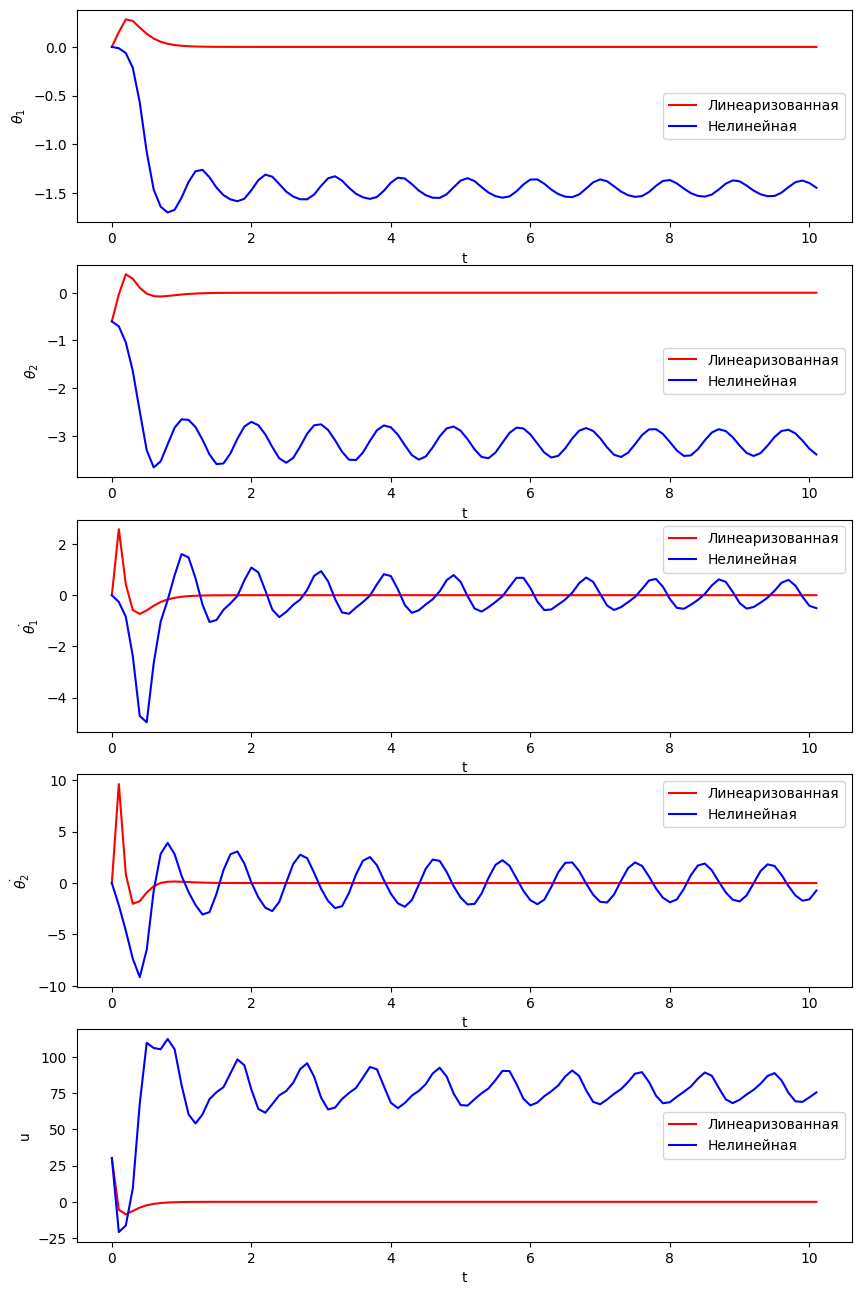

In [39]:
# Вычисление компонент состояний на временном промежутке
xi_lin = np.array([[0., -0.6, 0., 0.]]).T # 0., -0.3, 0., 0.
x_notlin = xi_lin
xis_lin = xi_lin
xs_notlin = x_notlin

vth_test = np.array(vth_test.tolist(), dtype=np.float64)

# mods = [-w[1], -w[2]] # Желаемые собственные числа
# theta = get_control(*mods)

u_lin = vth_test @ xi_lin
u_notlin = vth_test @ x_notlin

ts = [0] # время
h = 0.1
while ts[-1] < 3:
    t = ts[-1]
    xi_lin = f_test_discrete(t, xi_lin, vth_test)
    x_notlin = rk4(f_notlin, t, x_notlin, vth_test, h)

    xis_lin = np.append(xis_lin, xi_lin, axis=1)
    xs_notlin = np.append(xs_notlin, x_notlin, axis=1)

    u_lin = np.append(u_lin, vth_test @ xi_lin, axis=1)
    u_notlin = np.append(u_notlin, vth_test @ x_notlin, axis=1)

    ts.append(t+h)
  
fig = plt.figure(figsize=(10,16))


for i, y in zip(range(4), [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta_1}$", r"$\dot{\theta_2}$"]):
    plt.subplot(5, 1, i+1)
    plt.plot(ts, xis_lin[i,:], c='r', label="Линеаризованная")
    #plt.plot(ts, xs_notlin[i,:], c='b', label="Нелинейная")
    plt.xlabel("t")
    plt.ylabel(y)
    plt.legend()

plt.subplot(5, 1, 5)
plt.plot(ts, u_lin[0,:], c='r', label="Линеаризованная")
plt.plot(ts, u_notlin[0,:], c='b', label="Нелинейная")
plt.xlabel("t")
plt.ylabel("u")
plt.legend()

# fig.savefig(f"images/_{mods[0]},{mods[1]}")

pass

[[-65.40913679 197.35060019  12.85428817  23.76405044]]


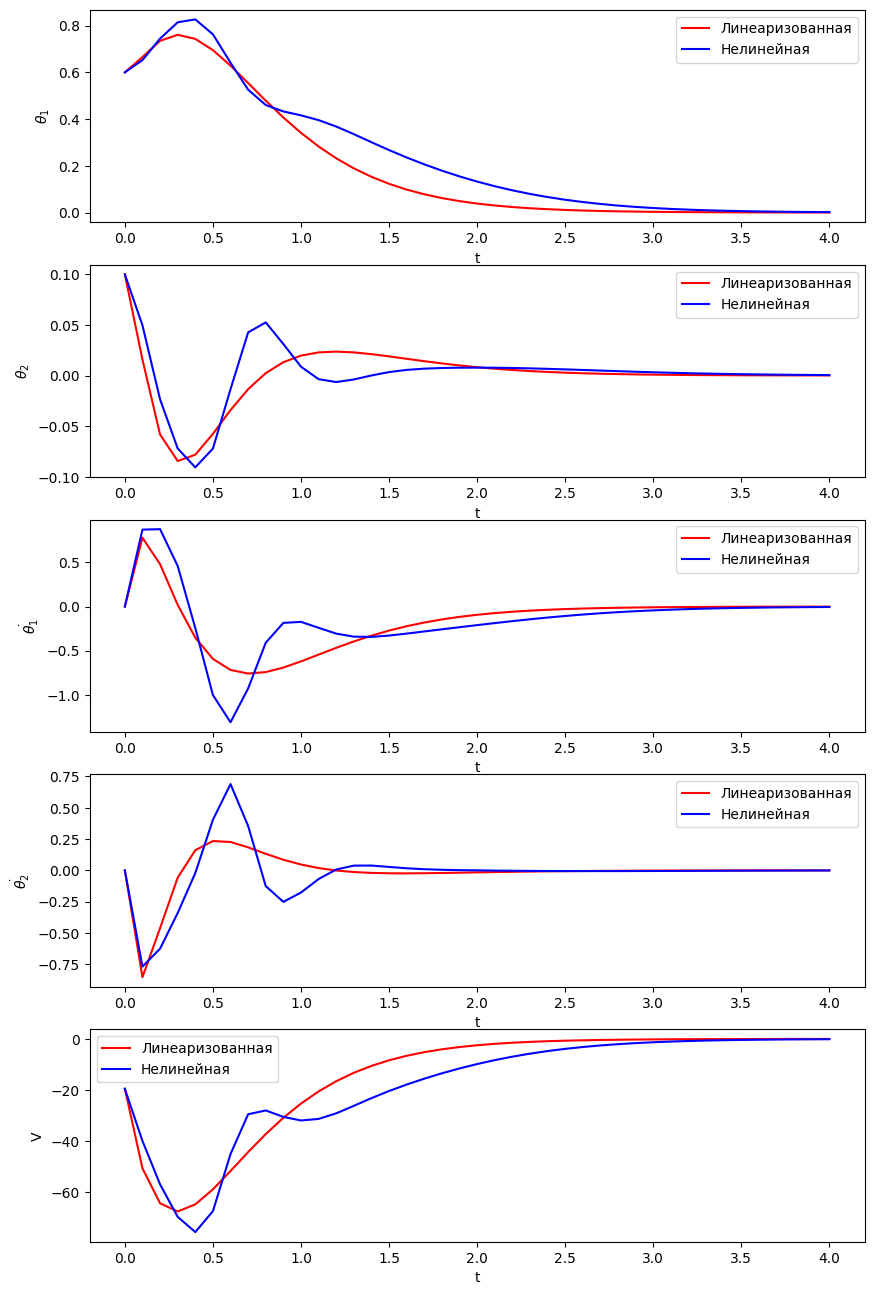

In [149]:
h = 0.1 # шаг, период
x_lin = np.array([[0.6, 0.1, 0., 0.]]).T # состояние линейной системы
x_notlin = x_lin # состояние нелинейной системы
xs_lin = x_lin
xs_notlin = x_notlin

mods = [-3, -3] # Желаемые собственные числа

theta = get_control(*mods)
print(theta)

u_lin = theta @ x_lin # управление в линейной системе
u_notlin = theta @ x_notlin # управление в нелинейной системе

ts = [0] # время

while ts[-1] < 4:
    t = ts[-1]
    x_lin = rk4(f_lin, t, x_lin, theta, h)
    x_notlin = rk4(f_notlin, t, x_notlin, theta, h)

    xs_lin = np.append(xs_lin, x_lin, axis=1)
    xs_notlin = np.append(xs_notlin, x_notlin, axis=1)

    u_lin = np.append(u_lin, theta @ x_lin, axis=1)
    u_notlin = np.append(u_notlin, theta @ x_notlin, axis=1)

    ts.append(t+h)


fig = plt.figure(figsize=(10,16))

for i, y in zip(range(4), [r"$\theta_1$", r"$\theta_2$", r"$\dot{\theta_1}$", r"$\dot{\theta_2}$"]):
    plt.subplot(5, 1, i+1)
    plt.plot(ts, xs_lin[i,:], c='r', label="Линеаризованная")
    plt.plot(ts, xs_notlin[i,:], c='b', label="Нелинейная")
    plt.xlabel("t")
    plt.ylabel(y)
    plt.legend()

plt.subplot(5, 1, 5)
plt.plot(ts, u_lin[0,:], c='r', label="Линеаризованная")
plt.plot(ts, u_notlin[0,:], c='b', label="Нелинейная")
plt.xlabel("t")
plt.ylabel("V")
plt.legend()

# fig.savefig(f"images/_{mods[0]},{mods[1]}")

pass